# Image denoising with an autoencoder

In this demo, we illustrate the use of convolutional networks to build an autoencoder for image denoising. We first load keras package and some other common package.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


## Get training and testing data and preprocessing

We get the natural images cifar10 dataset from keras build-in function. For more dataset information, you can check [Keras Document](https://keras.io/datasets/). Since we just need images for denoising, image label can be ignored. And we will just use 10000 samples for training and 1000 for test.

In [2]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train[:10000]
x_test = x_test[:1000]

We rescale x_train and x_test from 0 to 1 as this works better for the neural network.

In [3]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3)) # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3)) # adapt this if using `channels_first` image data format

We will generate synthetic noisy images: just apply a gaussian noise matrix with noise factor 0.5 on each image.

In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

Because piexl values may become out of range from 0 to 1 after noise is applied, we need to clip the images between 0 and 1.

In [5]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.) 

We can display 10 original images and corresponding noisy images. First row is original images and second row is noisy images.

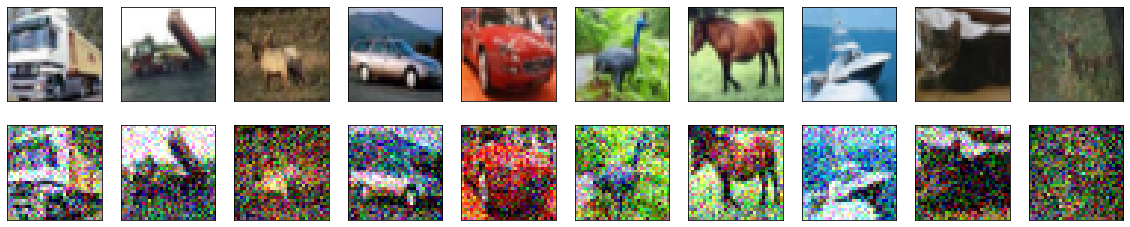

In [6]:
def plot_image(Nrow, Ncol, image_size, channel, *image_list):
    plt.figure(figsize=(2*Ncol, 2*Nrow))
    for i in range(1,Ncol+1):
        for j in range(len(image_list)):
            ax = plt.subplot(len(image_list), Ncol, i+j*Ncol)
            plt.imshow(image_list[j][i].reshape(image_size, image_size, channel))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
plot_image(2, 10, 32, 3, x_train, x_train_noisy)

## Set up an autoencoder and train the model

We construct a very simple auto-encoder with 2 convolution layer encoder each followed by a maxpooling layer (down sample by a factor of 2) and two convolution layer decoder, each followed by a upsampling layer, and a third conv layer that yields the denoised image. The output image have the same size as the input.  We will use batch normalization for each layer. We have found that adding drop out does not have much effect. You could try to add and evaluate the effect. Note that instead of using model.add( ) you could use the following procedures to add layers as well.

For reconstructing an image, a natural choice for the activation function of the output layer would be "linear". However, this does not guarantee the reconstructed values would be in the desired range of 0 to 1. Although we could clip the output image,  through experiments, we have found that using a sigmoid activation function is better. This may in part because it guarantees the output is in the range of 0 to 1. With the same number of epochs, using "linear" activiation yielded more blury images.

In [7]:
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K


K.clear_session()
input_img = Input(shape=(32,32,3))
x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPool2D((2,2), padding='same')(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
encoded = MaxPool2D((2,2), padding='same', name='encoded_layer')(x)

x = BatchNormalization()(encoded)
# x = Dropout(0.25)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)

Instructions for updating:
Colocations handled automatically by placer.


We can use summary() function to see model detail.

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 32)          128       
__________

As before, to train the network, we have to select an optimizer and a loss function. We select the mean_squared_error loss and the "adam" optimizer.

In [9]:
from keras import optimizers
opt = optimizers.Adam(lr=0.01)
autoencoder.compile(optimizer=opt, loss='mean_squared_error')

We now fit our model using x_train_noisy as input, and x_train as output. Because it takes times to train, we will run a small number of epochs. Because our validation set has a small size, the validation error may not be a reliable measure of test performance.

In [10]:
hist = autoencoder.fit(x_train_noisy, x_train,
                epochs=3,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 1000 samples
Epoch 1/3
10000/10000 [==============================] - 26s 3ms/step - loss: 0.0158 - val_loss: 0.0112
Epoch 2/3
10000/10000 [==============================] - 24s 2ms/step - loss: 0.0088 - val_loss: 0.0113
Epoch 3/3
10000/10000 [==============================] - 25s 2ms/step - loss: 0.0075 - val_loss: 0.0102


Let us see how the denoised images look. First row is original images, second row is noisy images, and third row shows corresponding denoised images.

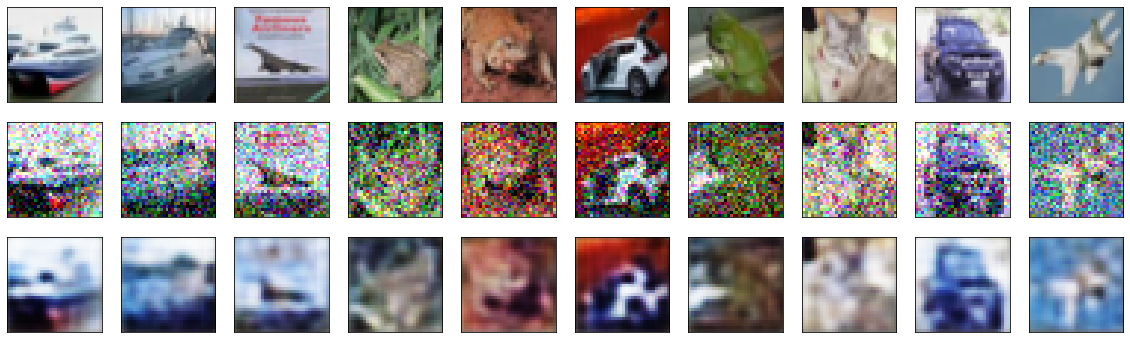

In [11]:
decoded_imgs = autoencoder.predict(x_test_noisy)
plot_image(3, 10, 32, 3, x_test, x_test_noisy, decoded_imgs)

Because we only run 3 epochs and the training set is relatively small,  the loss is still large. The denoised images look very blurred. If you want to get a more acceptable model to denoise, more epochs and more samples are needed. The following train the model using additional 97 epochs, yielding a model trained with 100 epochs. This model is saved, and can be loaded using the load_model() tool. You can check [Keras Document](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) for more information about how to load or save a model.

In [12]:
# Continue to train 97 epochs and save the model
# Skip this step for running the demo in class

hist = autoencoder.fit(x_train_noisy, x_train,
                epochs=97,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

autoencoder.save("cifar_autoencoder_100epochs.h5")



Train on 10000 samples, validate on 1000 samples
Epoch 1/97
10000/10000 [==============================] - 25s 3ms/step - loss: 0.0069 - val_loss: 0.0095
Epoch 2/97
10000/10000 [==============================] - 25s 3ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 3/97
10000/10000 [==============================] - 25s 3ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 4/97
10000/10000 [==============================] - 27s 3ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 5/97
10000/10000 [==============================] - 27s 3ms/step - loss: 0.0060 - val_loss: 0.0078
Epoch 6/97
10000/10000 [==============================] - 29s 3ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 7/97
10000/10000 [==============================] - 27s 3ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 8/97
10000/10000 [==============================] - 26s 3ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 9/97
10000/10000 [==============================] - 25s 3ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 

Epoch 78/97
10000/10000 [==============================] - 23s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 79/97
10000/10000 [==============================] - 24s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 80/97
10000/10000 [==============================] - 24s 2ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 81/97
10000/10000 [==============================] - 25s 3ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 82/97
10000/10000 [==============================] - 24s 2ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 83/97
10000/10000 [==============================] - 24s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 84/97
10000/10000 [==============================] - 24s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 85/97
10000/10000 [==============================] - 23s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 86/97
10000/10000 [==============================] - 23s 2ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 87/97
10000/10000 [=====================

Let us plot the training curves. We can see that although the training loss continuously decreasing, the validation loss is not stable. This is mainly because we used a very small validation set. A larger validation set should lead to a more stable loss curve.

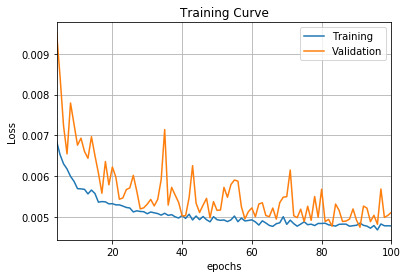

In [13]:
# plot loss curves
# Skip this if you you only trained for 3 epochs.

epochsn=np.arange(4, 101)
plt.plot(epochsn,hist.history['loss'])
plt.plot(epochsn,hist.history['val_loss'])
plt.xlim((4, 100))

plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend(['Training', 'Validation'])

plt.show()

## Evaluate the denoising performance visually 

In [14]:
from keras.models import load_model

autoencoder = load_model('./cifar_autoencoder_100epochs.h5')

Let us see how the denoised images look with this model. We plot denoised images from both the testing set and the training set.

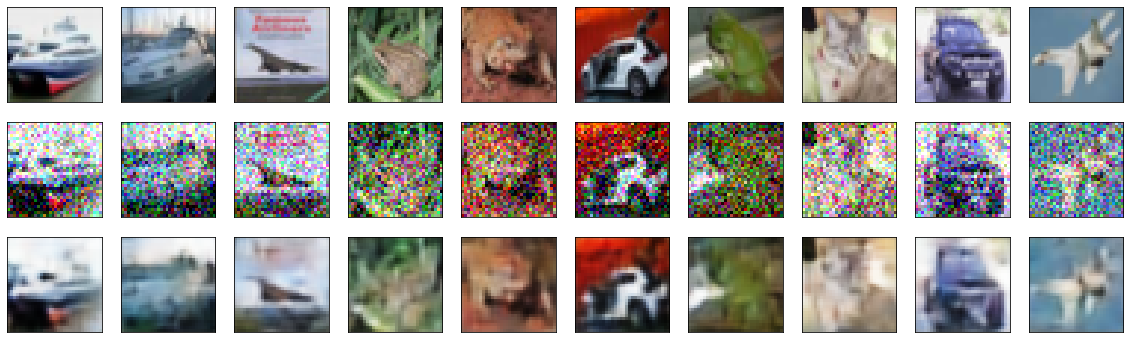

In [15]:

decoded_test_imgs = autoencoder.predict(x_test_noisy[:11])
plot_image(3, 10, 32, 3, x_test, x_test_noisy, decoded_test_imgs)

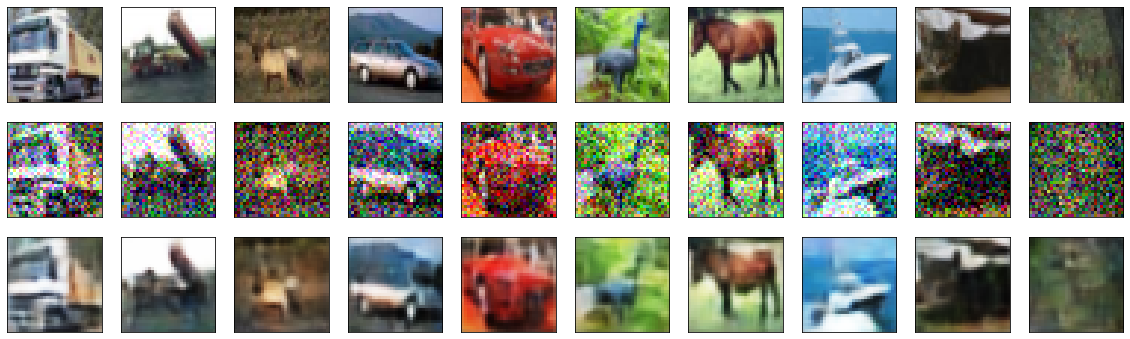

In [16]:
decoded_train_imgs = autoencoder.predict(x_train_noisy[:11])
# decoded_imgs = autoencoder.predict(x_test_noisy)
plot_image(3, 10, 32, 3, x_train, x_train_noisy, decoded_train_imgs)

We see that  with this pretrained model, denoised images for those in training data are noticeably better. For better results, we need to train with more data. Also, using MSE alone often lead to blurred images. Using a advasarial discriminator loss (as in Generative Advasarial Network) in addition to MSE can help to reduce blurring. You can look into those on your own.

## How do the encoded feature maps look?
Let us take a look at encoded image of a test sample. First let us plot an noisy image

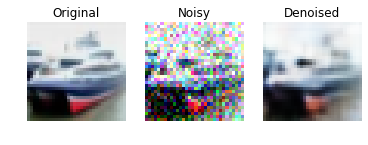

In [17]:
test_original = x_test[1]
test_sample = x_test_noisy[1]
test_denoised = decoded_test_imgs[1]

plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow(test_original)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test_sample)
plt.title('Noisy')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_denoised)
plt.title('Denoised')
plt.axis('off')

plt.show()



Then put test sample into model and plot encoded noised image

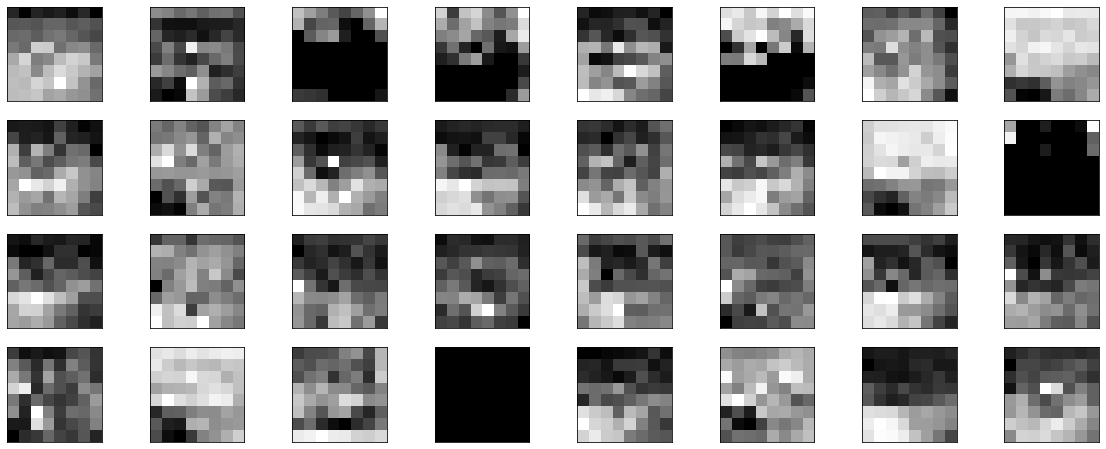

In [18]:
# model input should have 4 dimension: batch_size * length * width * channel
test_sample_expanded = np.expand_dims(test_sample, axis=0)
layer_name = 'encoded_layer'
encout_output_layer = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
encode_image = encout_output_layer.predict(test_sample_expanded)[0]
n = 8 
plt.figure(figsize=(20, 8))
for i in range(0, 8):
    ax = plt.subplot(4, n, i+1)
    plt.imshow(encode_image[:,:,i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i+n+1)
    plt.imshow(encode_image[:,:,i+n].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i+2*n+1)
    plt.imshow(encode_image[:,:,i+2*n].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i+3*n+1)
    plt.imshow(encode_image[:,:,i+3*n].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We see that some feature maps are completely zero. This suggests that we may not need 32 channels for the encoded features. You may wonder how the decoder generates the denoised image from these features .... That is the mystry of deep network!